In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pandas as pd
import sys
sys.path.append('/home/yat-lok/workspace/tvbtools/')
from tools.signaltools import SignalToolkit
import ipywidgets as widgets
my_layout = widgets.Layout()
import typing
from typing import List
import seaborn as sns

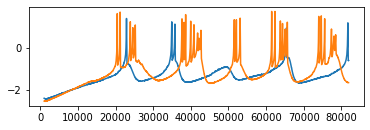

In [2]:
# read data
filename = '/mnt/d/data/LFP/SNC/2820A/2820A_0.014.csv'
df = pd.read_csv(filename)
df_left = df.iloc[1024:,5]
df_right = df.iloc[1024:,6]
df_right_low = SignalToolkit.hamming_filter(df_right, Wn=[2,2.1], fNQ=81920/2, n=256)
df_right_high = SignalToolkit.hamming_filter(df_right, Wn=[60,100], fNQ=81920/2, n=2048)
df_left_low = SignalToolkit.hamming_filter(df_left, Wn=[2,2.1], fNQ=81920/2, n=256)
df_left_high = SignalToolkit.hamming_filter(df_left, Wn=[60,100], fNQ=81920/2, n=2048)
# # visualize results
fig = plt.figure()
axes = fig.add_subplot(211)
axes.plot(df_left)
axes.plot(df_right)
plt.show()


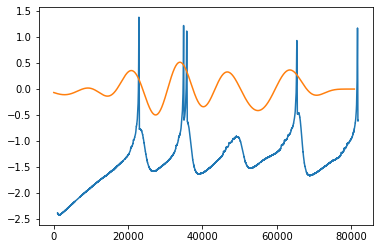

In [3]:
y = SignalToolkit.sos_filter(df_left, [2,8], 81920)
plt.plot(df_left)
plt.plot(y)
plt.show()

In [4]:
# %matplotlib widget
# # hilbert transform
# # step 1, get the amplitude envelop of high freq
# h1=signal.hilbert(df_left_high)
# amplitude_envelope = np.abs(h1)

# # step 2, get the phase information of low freq
# l1 = signal.hilbert(df_left_low)
# phase_y1=np.angle(l1)

# # step 3 bin the phase
# cycle = len(l1)/360
# stamp = range(int(cycle))
# phase_amp = []
# for i in stamp:
#     amp_value = np.mean(amplitude_envelope[i*360:(i+1)*360])
#     phase_amp.append(amp_value)
# # step 4, entropy method H
# p_j = [p_j_single/np.sum(phase_amp) for p_j_single in phase_amp]
# cap_H = -np.sum(p_j * np.log(p_j))

# # step 5, calculate the MI
# MI = (np.log(len(stamp))-cap_H) / np.log(len(stamp))
# print(MI)

# x_axes1 = [*stamp]

# fig = plt.figure()
# axes1 = fig.add_subplot(221)
# axes1.bar(x_axes1, phase_amp)

# # graph 2
# axes2 = fig.add_subplot(222)
# axes2.set_title("raw plot with low and high \nfrequency bands signal")
# axes2.plot(df_left)
# axes2.plot(df_left_low)
# axes2.plot(df_left_high)

# axes3 = fig.add_subplot(223)
# axes3.plot(df_left_high)
# axes3.plot(amplitude_envelope)

# axes4 = fig.add_subplot(224)
# axes4.plot(df_left_low)
# axes4.plot(phase_y1, "o")
# plt.show()

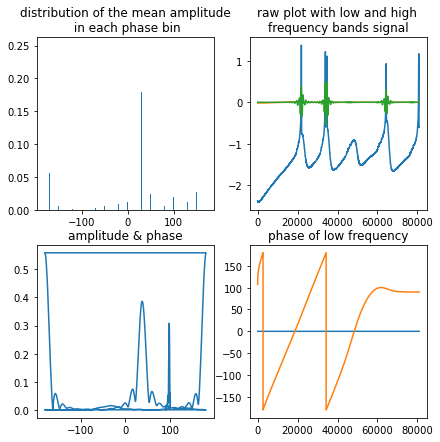

0.257087203449779


In [7]:
def PAC(data, low_win, high_win, fs=81920, n_bins=36, visual=False):
    """
    Parameters:
    ---------------
        data:list or np.ndarray
            signal
        low_win:list
            start frequency, stop frequency
        high_win:list
            start frequency, stop frequency
    Returns:
    --------------
        Modulation Index (MI)
    """

    # def sign_check(data):
    #     signs = np.sign(data)
    #     places = []
    #     for ii in range(1, len(signs)):
    #         if signs[ii] != signs[ii-1]:
    #             places.append(ii)
    #     return len(places)

    # unify data format
    data = np.array(data)
    # filtering data into high frequency band and low frequency band
    low_freq = SignalToolkit.sos_filter(data, low_win, fs=fs)
    high_freq = SignalToolkit.sos_filter(data, high_win, fs=fs)
    # hilbert transform
    # step 1, get the amplitude envelop of high freq
    h1=signal.hilbert(high_freq)
    amplitude_envelope = np.abs(h1)
    # step 2, get the phase information of low freq
    l1 = signal.hilbert(low_freq)
    phase_y1=np.degrees(np.angle(l1))
    # step 3 bin the phase
    binsize = 360/ n_bins
    phase_bins = np.arange(-180,180,binsize)
    amp_mean = np.zeros(len(phase_bins)) 
    for k in range(len(phase_bins)):
        phase_range = np.logical_and(phase_y1 >= phase_bins[k],
                                    phase_y1 < (phase_bins[k] + binsize))
        tmp_amp = amplitude_envelope[phase_range]
        amp_mean[k] = np.mean(tmp_amp)   
    # step 4, entropy method H
    p_j = amp_mean / np.sum(amp_mean)
    # cap_H = -np.sum(p_j * np.log(p_j))
    # # step 5, calculate the MI
    # MI = (np.log(len(phase_bins))-cap_H) / np.log(len(phase_bins))
    # kl_pu = np.log(len(phase_bins)) + np.sum(p_j * np.log(p_j))
    # MI = kl_pu/np.log(len(phase_bins))
    # print(f"Modulation Index = {MI}")
    if np.any(p_j == 0):
        p_j[p_j == 0] = np.finfo(float).eps

    H = -np.sum(p_j * np.log10(p_j))
    Hmax = np.log10(n_bins)
    KL = Hmax - H
    MI = KL / Hmax
    if visual:
        fig = plt.figure(figsize=(7,7))
        # graph 1
        axes1 = fig.add_subplot(221)
        axes1.set_title("distribution of the mean amplitude\n in each phase bin")
        axes1.bar(phase_bins, amp_mean)
        # graph 2
        axes2 = fig.add_subplot(222)
        axes2.set_title("raw plot with low and high \nfrequency bands signal")
        axes2.plot(data)
        axes2.plot(low_freq)
        axes2.plot(high_freq)
        # graph 3
        axes3 = fig.add_subplot(223)
        axes3.set_title("amplitude & phase")
        axes3.plot(phase_y1, amplitude_envelope)
        # graph 4
        axes4 = fig.add_subplot(224)
        axes4.set_title("phase of low frequency")
        axes4.plot(low_freq)
        axes4.plot(phase_y1)
        plt.show()
    return MI


data = df_left
low_win = [2,3]
high_win = [60,120]
mm = PAC(data, low_win, high_win, fs=81920, visual=True)
print(mm)

         30        40        50        60        70        80        90   \
2   0.040660  0.011563  0.028553  0.020679  0.024352  0.026836  0.019820   
4   0.007824  0.010526  0.005992  0.009514  0.006035  0.007248  0.007938   
6   0.008505  0.005099  0.005441  0.015392  0.013324  0.005279  0.004609   
8   0.004699  0.003534  0.003722  0.004487  0.005534  0.004675  0.003831   
10  0.005562  0.004443  0.003277  0.004875  0.006914  0.005237  0.004492   
12  0.004462  0.003768  0.003155  0.004557  0.005020  0.005031  0.003731   
14  0.003087  0.003018  0.003021  0.003091  0.003277  0.003066  0.002923   
16  0.004183  0.003801  0.002829  0.003904  0.004869  0.004571  0.003500   
18  0.003903  0.003684  0.003056  0.003665  0.004527  0.004047  0.003349   

         100       110       120       130       140       150       160  \
2   0.010520  0.014341  0.021002  0.022256  0.016737  0.022969  0.007873   
4   0.016403  0.004373  0.004780  0.011829  0.015145  0.023448  0.008381   
6   0.00544

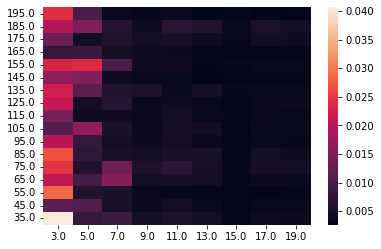

In [69]:
def PAC_comodulogram(data, low_paras, high_paras, fs, visual=False):
    data = np.array(data)
    phase_x = np.arange(*low_paras)
    amplitude_y = np.arange(*high_paras)
    como_df = pd.DataFrame(index=phase_x, columns=amplitude_y)
    for xi, i in enumerate(phase_x):
        for yi, j in enumerate(amplitude_y):
            mi = PAC(data, [i, phase_x[xi]+low_paras[2]], [j, amplitude_y[yi]+high_paras[2]], fs=fs, visual = visual)
            como_df.iloc[xi,yi] = mi
            como_df[como_df.columns[yi]] = como_df[como_df.columns[yi]].astype(float, errors = 'raise')
    como_df.columns += high_paras[2]/2
    como_df.index += low_paras[2]/2
    fig = plt.figure()
    axes = fig.add_subplot(111)
    
    sns.heatmap(como_df.transpose(), ax = axes )
    axes.invert_yaxis()

    #_developing
    # old_ticks = axes.get_xticks()
    # new_ticks = np.linspace(np.min(old_ticks), np.max(old_ticks), len(phase_x))
    # axes.set_xticks(new_ticks)
    # axes.set_xticklabels()
    
    plt.show()

PAC_comodulogram(df_right, [2,20,2],[30, 200, 10], fs=81920)

           20        30        40        50        60        70        80
1.0  0.000733  0.000402  0.000579  0.000741  0.000482  0.000454  0.000541
1.2  0.000891  0.000353  0.000817  0.000591  0.000474  0.000339  0.000627
1.4  0.000376  0.000476  0.000371  0.000423  0.000589  0.000500  0.000475
1.6  0.000580  0.000386  0.000645  0.000168  0.000547  0.000427  0.000565
1.8  0.000403  0.000158  0.000418  0.000475  0.000565  0.000689  0.000318
2.0  0.000659  0.000366  0.000214  0.000388  0.000344  0.000097  0.000559
2.2  0.000195  0.000606  0.000138  0.000601  0.000121  0.000150  0.000294
2.4  0.000064  0.000177  0.000501  0.000326  0.000231  0.000091  0.000299
2.6  0.000232  0.000196  0.000205  0.000314  0.000113  0.000098  0.000167
2.8  0.000210  0.000230  0.000042  0.000126  0.000217  0.000281  0.000072
3.0  0.000162  0.000101  0.000100  0.000125  0.000178  0.000215  0.000404
3.2  0.000116  0.000258  0.000053  0.000183  0.000289  0.000076  0.000099
3.4  0.000158  0.000296  0.000110  0.0

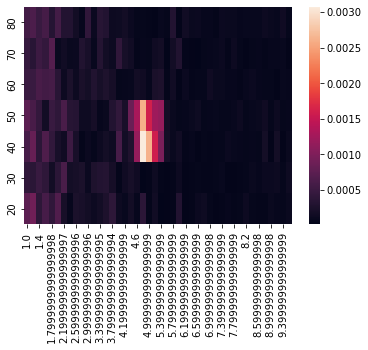

ozkurt... 
canolty... 
tort... 
penny... 
vanwijk... 
duprelatour... 
colgin... 
sigl... 
bispectrum... 


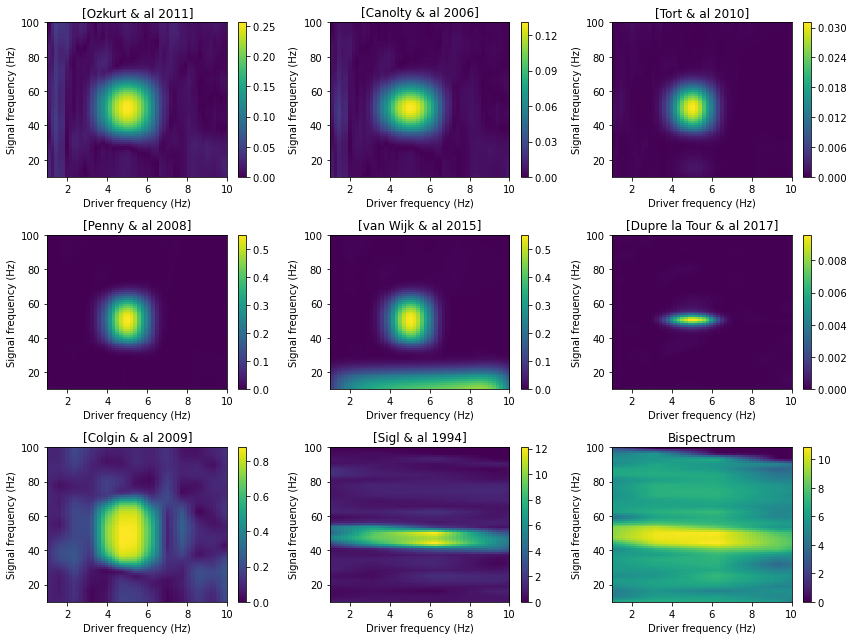

In [15]:
import numpy as np
import matplotlib.pyplot as plt

from pactools import Comodulogram, REFERENCES
from pactools import simulate_pac

fs = 200.  # Hz
high_fq = 50.0  # Hz
low_fq = 5.0  # Hz
low_fq_width = 1.0  # Hz

n_points = 10000
noise_level = 0.4

signala = simulate_pac(n_points=n_points, fs=fs, high_fq=high_fq, low_fq=low_fq,
                      low_fq_width=low_fq_width, noise_level=noise_level,
                      random_state=0)

PAC_comodulogram(signala, [1,10,0.2],[20, 100, 10], fs=200)

# signala = df_left

low_fq_range = np.linspace(1, 10, 50)
methods = [
    'ozkurt', 'canolty', 'tort', 'penny', 'vanwijk', 'duprelatour', 'colgin',
    'sigl', 'bispectrum'
]


# Define the subplots where the comodulogram will be plotted
n_lines = 3
n_columns = int(np.ceil(len(methods) / float(n_lines)))
fig, axs = plt.subplots(
    n_lines, n_columns, figsize=(4 * n_columns, 3 * n_lines))
axs = axs.ravel()


# Compute the comodulograms and plot them
for ax, method in zip(axs, methods):
    print('%s... ' % (method, ))
    estimator = Comodulogram(fs=fs, low_fq_range=low_fq_range,
                             low_fq_width=low_fq_width, method=method,
                             progress_bar=False)
    estimator.fit(signala)
    estimator.plot(titles=[REFERENCES[method]], axs=[ax])

plt.show()